In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import xgboost.sklearn as xgb
import xgboost as x
import gensim
import seaborn as sns
import pickle
import nlp_pipeline as nlp
import ml_functions as ml
# %load_ext autoreload
%autoreload 2
style.use('ggplot')
rcParams['font.size'] = 14
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'large'

In [2]:
df = pd.read_csv('../data/train.csv')
df = df[df['Labels'] != 4].copy()
df['target'] = np.where((df['Labels'] == 3) | (df['Labels'] == 5), 0, 1)
df.head(10)

,Labels,Text,Text_Tag,target
0,1,Says the Annies List political group supports ...,abortion,1
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",1
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,0
3,1,Health care reform legislation is likely to ma...,health-care,1
4,2,The economic turnaround started at the end of ...,"economy,jobs",1
5,5,The Chicago Bears have had more starting quart...,education,0
6,0,Jim Dunnam has not lived in the district he re...,candidates-biography,1
7,2,I'm the only person on this stage who has work...,ethics,1
8,2,"However, it took $19.5 million in Oregon Lotte...",jobs,1
9,3,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",0


In [24]:
df[['target','Text']].head(10)

,target,Text
0,1,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,0,"Hillary Clinton agrees with John McCain ""by vo..."
3,1,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...
5,0,The Chicago Bears have had more starting quart...
6,1,Jim Dunnam has not lived in the district he re...
7,1,I'm the only person on this stage who has work...
8,1,"However, it took $19.5 million in Oregon Lotte..."
9,0,Says GOP primary opponents Glenn Grothman and ...


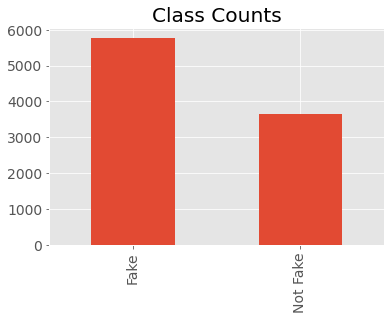

In [3]:
df.target.value_counts().plot(kind='bar')
plt.xticks(df.target.unique(), ['Not Fake','Fake'])
plt.title('Class Counts');

In [4]:
fname = '../models/pca_5c_maxfeats.sav'
pca_loaded = pickle.load(open(fname, 'rb'))

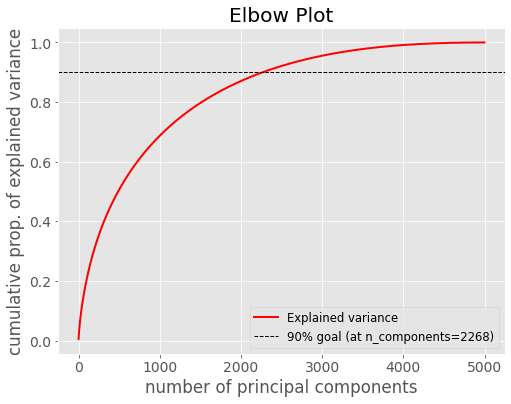

In [5]:
comp = ml.elbow_plot(pca_loaded)

In [6]:
X = df['Text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
stopwords_ = set(stopwords.words('english'))

tfidf = TfidfVectorizer(stop_words=stopwords_, max_features=5000)
words_train = tfidf.fit_transform(X_train).toarray()
words_test = tfidf.transform(X_test).toarray()
feats = tfidf.get_feature_names()

In [8]:
words_tr_pca = pca_loaded.transform(words_train)
words_tst_pca = pca_loaded.transform(words_test)

In [9]:
X_pca_train = words_tr_pca[:,:comp]
X_pca_test = words_tst_pca[:,:comp]

In [10]:
X_pca_train.shape, X_pca_test.shape

((7520, 2268), (1881, 2268))

In [11]:
params = {
            'n_estimators': [200,250,300,350],
#             'max_features': [40,50,60],
            'max_depth': [5,10,15,20]
         }

rf_be = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=6), 
                           params, 
#                            random_state=0, 
                           scoring='roc_auc',
                           return_train_score=True)

search = rf_be.fit(X_pca_train, y_train)
search.best_params_

{'max_depth': 10, 'n_estimators': 350}

In [12]:
y_pred = search.predict(X_pca_test)
y_proba = search.predict_proba(X_pca_test)[:,1]

print('Train:')
ml.get_scores(y_train, search.predict(X_pca_train), search.predict_proba(X_pca_train)[:,1])
print('\nTest:')
ml.get_scores(y_test, y_pred, y_proba)

Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2910
           1       1.00      1.00      1.00      4610

    accuracy                           1.00      7520
   macro avg       1.00      1.00      1.00      7520
weighted avg       1.00      1.00      1.00      7520

[[2904    6]
 [   1 4609]]
ROC AUC: 0.9999897876273752

Test:
              precision    recall  f1-score   support

           0       0.50      0.08      0.14       728
           1       0.62      0.95      0.75      1153

    accuracy                           0.61      1881
   macro avg       0.56      0.52      0.45      1881
weighted avg       0.57      0.61      0.51      1881

[[  61  667]
 [  62 1091]]
ROC AUC: 0.6051449634493866


In [22]:
alg = xgb.XGBClassifier(
                       n_estimators=500, 
                       learning_rate=0.01,
                       max_depth=3,
                       colsample_bytree=0.8,
                       min_child_weight=3,
                       gamma=0,
                       subsample=0.8,
                       scale_pos_weight=0.62,
                       n_jobs=-1,
                       seed=27)

ml.modelfit(alg, X_pca_train, y_train)

Num of n_estimators: 151

Model Report
              precision    recall  f1-score   support

           0       0.62      0.82      0.71      2910
           1       0.86      0.68      0.76      4610

    accuracy                           0.74      7520
   macro avg       0.74      0.75      0.73      7520
weighted avg       0.77      0.74      0.74      7520

AUC Score (Train): 0.8352317164985725


In [21]:
params = {
             'max_depth': [3],    # d-6
#             'reg_alpha': (0, 0.01),       # Lasso (L1) d-0
#             'reg_lambda': (1, 5, 10),   # Ridge (L2)   d-1
             'colsample_bytree': [0.8],
             'gamma': [0],   # d-0
             'min_child_weight': [3],   # d-1
             'subsample': [0.8],  # d-1 ... do 0.5 or something in the middle
             'n_estimators': [160],
             'scale_pos_weight': [0.62]
         }
gb = xgb.XGBClassifier(learning_rate=0.01, n_jobs=-1)

search = GridSearchCV(gb, 
                           params, 
#                            random_state=0, 
                           scoring='roc_auc',
                           return_train_score=True)
search.fit(X_pca_train, y_train)
search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 160,
 'scale_pos_weight': 0.62,
 'subsample': 0.8}

In [22]:
y_pred = search.predict(X_pca_test)
y_proba = search.predict_proba(X_pca_test)[:,1]

print('Train:')
ml.get_scores(y_train, search.predict(X_pca_train), search.predict_proba(X_pca_train)[:,1])
print('\nTest:')
ml.get_scores(y_test, y_pred, y_proba)

Train:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      2910
           1       0.86      0.70      0.77      4610

    accuracy                           0.75      7520
   macro avg       0.75      0.76      0.74      7520
weighted avg       0.77      0.75      0.75      7520

[[2387  523]
 [1372 3238]]
ROC AUC: 0.8475543231135065

Test:
              precision    recall  f1-score   support

           0       0.44      0.56      0.50       728
           1       0.67      0.56      0.61      1153

    accuracy                           0.56      1881
   macro avg       0.56      0.56      0.55      1881
weighted avg       0.58      0.56      0.56      1881

[[410 318]
 [512 641]]
ROC AUC: 0.5937437454133031


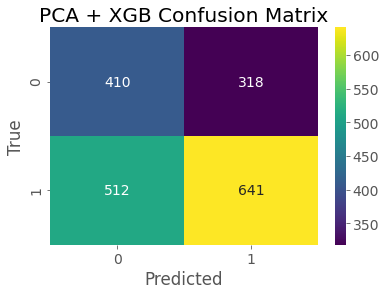

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('PCA + XGB Confusion Matrix');

In [31]:
results = pd.read_clipboard()

In [32]:
results.set_index('Model', inplace=True)

In [33]:
results

,Accuracy,F1 Weighted,ROC AUC,Recall,Precision
Model,,,,,
PCA RF,0.61,0.51,0.61,0.946227,0.620592
PCA XGB,0.56,0.56,0.59,0.555941,0.668405
WV50 RF,0.57,0.58,0.59,0.577624,0.666000
WV50 XGB,0.56,0.57,0.59,0.558543,0.664603
WV1000 RF,0.56,0.56,0.58,0.610581,0.662277
WV1000 XGB,0.56,0.56,0.58,0.556808,0.665285


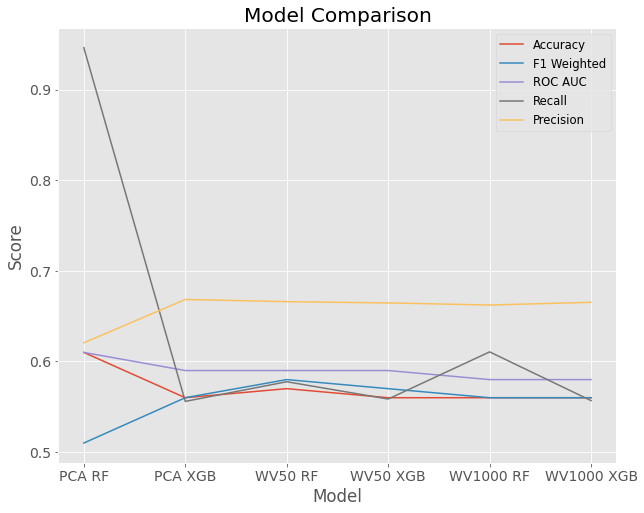

In [43]:
results.plot(figsize=(10,8))
plt.title('Model Comparison')
plt.ylabel('Score');